In [171]:
import pandas as pd
import numpy as np


In [249]:
#Load Dataset

df_feedback = pd.read_csv('Customer_Feedback.csv')
df_inventory = pd.read_csv("Inventory.csv")
df_production = pd.read_csv("Production_Orders.csv")
df_sales = pd.read_csv("Sales.csv")
df_shipments = pd.read_csv("Shipments.csv")
df_suppliers = pd.read_csv("Suppliers.csv")


In [251]:
#Display first few rows
df_sales.head()

,Sale_ID,Product_ID,Sale_Date,Quantity_Sold,Revenue,Region
0,SA006,INV006,2024-01-27,300,"$1,700",Mumbai
1,SA007,INV007,2024-01-29,150,"$1,200",Kolkata
2,SA008,INV008,2024-02-01,250,"$2,100",Noida
3,SA009,INV009,2024-02-03,200,"$1,600",Lucknow
4,SA010,INV010,2024-02-05,350,"$2,500",Ahmedabad


In [253]:
#Convert date columns to datetime

date_columns = { "df_feedback": ["Feedback_Date"],
    "df_production": ["Order_Date", "Completion_Date"],
    "df_sales": ["Sale_Date"],
    "df_shipments": ["Shipping_Date", "Delivery_Date"],}

for df_name, cols in date_columns.items():
    df = globals()[df_name]  # Get the dataframe
    for col in cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')


In [255]:
# Check the changes

df_feedback.dtypes

Feedback_ID                object
Product_ID                 object
Customer_Rating           float64
Feedback_Date      datetime64[ns]
Comments                   object
dtype: object

In [257]:
# Remove "$" sign from Revenue and Shipping Cost, then convert to float

df_sales["Revenue"] = df_sales["Revenue"].replace('[$,]', '', regex=True).astype(int)
df_shipments["Shipping_Cost"] = df_shipments["Shipping_Cost"].replace('[$,]', '', regex=True).astype(int)


In [259]:
df_sales.head()

,Sale_ID,Product_ID,Sale_Date,Quantity_Sold,Revenue,Region
0,SA006,INV006,2024-01-27,300,1700,Mumbai
1,SA007,INV007,2024-01-29,150,1200,Kolkata
2,SA008,INV008,2024-02-01,250,2100,Noida
3,SA009,INV009,2024-02-03,200,1600,Lucknow
4,SA010,INV010,2024-02-05,350,2500,Ahmedabad


In [261]:
# Fill missing values with NaN where necessary

df_feedback.fillna(np.nan, inplace=True)
df_production.fillna(np.nan, inplace=True)
df_sales.fillna(np.nan, inplace=True)
df_shipments.fillna(np.nan, inplace=True)
df_suppliers.fillna(np.nan, inplace=True)


In [263]:
# check column names

df_production.columns

Index(['Order_ID', 'Product_ID', 'Quantity_Ordered', 'Order_Date',
       'Completion_Date', 'Status'],
      dtype='object')

Exploratory Data Analysis

1)Top-Selling Products & Trends

In [325]:

# Merge Sales with Inventory to get Product Names
df_sales_merged = df_sales.merge(df_inventory[["Product_ID", "Product_Name"]], on="Product_ID", how="left")

# Aggregate sales by product with product names
top_selling = df_sales_merged.groupby(["Product_Name"])["Quantity_Sold"].sum().sort_values(ascending=False)

print(top_selling.head(10))  # Display Top 10 Selling Products



Product_Name
Calcium Tablets           350
Anti-Dandruff Shampoo     340
Energy Boost Tablets      330
Omega 3 Fish Oil          320
Antibacterial Soap        320
Iron Tablets              310
Blood Pressure Tablets    310
Vitamin A Drops           300
Muscle Pain Balm          300
Glucose Powder            300
Name: Quantity_Sold, dtype: int64


2) Suppliers With the Most Delays

In [345]:

# Drop duplicate Supplier_Name column if it exists before merging
if "Supplier_Name" in df_merged.columns:
    df_merged.drop(columns=["Supplier_Name"], inplace=True)

# Merge Suppliers Data to Get Supplier Name
df_merged = df_merged.merge(df_suppliers[["Supplier_ID", "Supplier_Name"]], on="Supplier_ID", how="left")

# Aggregate Supplier Delays with Supplier Names
supplier_delays = df_merged.groupby(["Supplier_ID", "Supplier_Name"]) ["Production_Delay_Days"].mean().sort_values(ascending=False)

print(supplier_delays)



Supplier_ID  Supplier_Name  
SUP023       EssentialChem      11.0
SUP022       SpeedLogistics     11.0
SUP021       HealthChemicals    11.0
SUP020       FastPack           11.0
SUP019       ChemReliable       11.0
SUP006       PharmaPlus         10.0
SUP030       PackExcellence     10.0
SUP007       PackWell           10.0
SUP029       RapidMaterials     10.0
SUP031       ChemSupply         10.0
Name: Production_Delay_Days, dtype: float64


The results identifies the suppliers with the highest average production delays and that could be unreliable.


3) Which Regions Generate the Highest Sales?

In [347]:

sales_by_region = df_sales.groupby("Region")["Revenue"].sum().sort_values(ascending=False)

print(sales_by_region.head(5))


Region
Vijayawada    3000
Aurangabad    2800
Jaipur        2800
Siliguri      2700
Mysore        2700
Name: Revenue, dtype: int64


The result helps us target high-revenue regions for better inventory distribution.

4) Analyzing Supplier Lead Time vs. Production Delays

In [267]:

# Calculate Production Delay (Completion Date - Order Date)
df_production["Production_Delay_Days"] = (df_production["Completion_Date"] - df_production["Order_Date"]).dt.days


 Merge Production Orders with Suppliers

In [270]:
# Merge Production Orders with Inventory (to get Supplier_ID)
df_merged = df_production.merge(df_inventory, on="Product_ID", how="left")

# Merge with Suppliers to get Lead Time
df_merged = df_merged.merge(df_suppliers, on="Supplier_ID", how="left")


Compute Correlation Between Lead Time & Production Delay

In [273]:
# Compute correlation
correlation = df_merged[["Lead_Time_Days", "Production_Delay_Days"]].corr()

print(correlation)


                       Lead_Time_Days  Production_Delay_Days
Lead_Time_Days               1.000000              -0.043918
Production_Delay_Days       -0.043918               1.000000


This result shows -0.044, which is very weak negative correlation. 
This means longer supplier lead times do not strongly impact production delays.

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

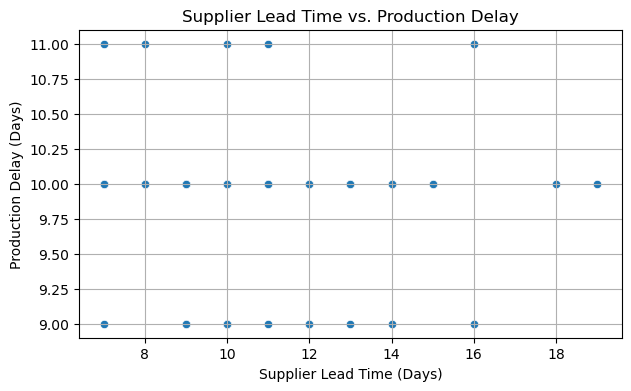

In [278]:
# Scatter plot: Supplier Lead Time vs. Production Delay


plt.figure(figsize=(7, 4))
sns.scatterplot(x=df_merged["Lead_Time_Days"], y=df_merged["Production_Delay_Days"])
plt.xlabel("Supplier Lead Time (Days)")
plt.ylabel("Production Delay (Days)")
plt.title("Supplier Lead Time vs. Production Delay")
plt.grid(True)
plt.show()

5) Identify Products With Low Inventory

In [299]:
# Identify products with stock below reorder level

low_inventory = df_inventory[df_inventory["Quantity_Available"] <= df_inventory["Reorder_Level"]]
print(low_inventory)



Empty DataFrame
Columns: [Product_ID, Product_Name, Quantity_Available, Reorder_Level, Warehouse_Location, Supplier_ID]
Index: []


In [285]:
# Merge Inventory with Sales to see if stock-outs affect sales

df_sales_inventory = df_sales.merge(df_inventory, on="Product_ID", how="left")


In [329]:
# Group by Product_ID and check total sales vs. inventory levels

sales_vs_inventory = df_sales_inventory.groupby("Product_ID")[["Quantity_Available", "Quantity_Sold"]].sum()


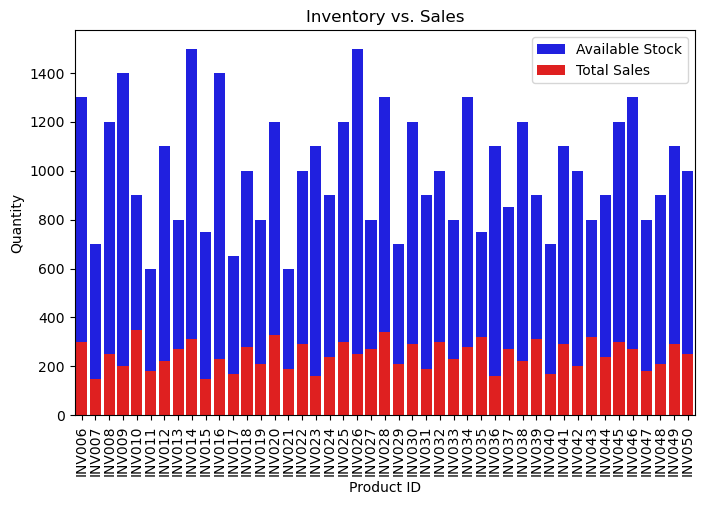

In [311]:
#Visualization

plt.figure(figsize=(8, 5))
sns.barplot(x=sales_vs_inventory.index, y=sales_vs_inventory["Quantity_Available"], color="blue", label="Available Stock")
sns.barplot(x=sales_vs_inventory.index, y=sales_vs_inventory["Quantity_Sold"], color="red", label="Total Sales")
plt.xticks(rotation=90)
plt.xlabel("Product ID")
plt.ylabel("Quantity")
plt.title("Inventory vs. Sales")
plt.legend()
plt.show()
